# Set Up

In [208]:
from dataclasses import dataclass
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

In [209]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())
else:
    print("No GPU, using CPU")

Quadro P5000


For code simplicity, we can define some model parameters for use within our components. The default values are those of the original transformer (base size).

In [233]:
@dataclass
class ModelArgs:
    d_model: int = 512 #size of the embedding vectors
    d_ff: int = 2048 #size of the hidden dimensions of the feed forward networks
    N: int=6 #the number of encoder and decoder layers
    dropout: float = 0.1 
    num_heads: int = 8 #the number of heads in each attention block
    vocab_size: int = 50000 #the size of the vocabulary
    pad_idx : int = 0 #index of the padding token 
    max_seq_len: int = 100

model_args=ModelArgs(vocab_size=10)


## Embeddings

In [211]:
class Embeddings(nn.Module):
    def __init__(self, args:ModelArgs):
        super().__init__()
        self.embedding = nn.Embedding(args.vocab_size, args.d_model)
        self.d_model = args.d_model
    
    def forward(self, x):
        return self.embedding(x)*self.d_model**0.5

In [212]:
emb = Embeddings(model_args)
print(emb)

print("Vocab size: ", model_args.vocab_size)

Embeddings(
  (embedding): Embedding(10, 512)
)
Vocab size:  10


The embeddings model expects a tensor of token_ids, where the id corresponds to that token's id within
our vocabulary. Let's create an example sentence and transform it into the desired input. For now we will tokenize the sentence by splitting into words, and their
ids will be assigned in alphabetical order. Our vocabulary will just be the words in our sentence.

Note: Although we are working with a single sentence, and our batch size is only 1, it's important to transform our sentence
into a batch as our code expects this.

In [213]:
sentence = "watch me transform from a simple sentence to an embedding"
print(sentence)

sentence_dict = {word: i for i,word in enumerate(sorted(sentence.split()))}
print("Tokens: token_id", sentence_dict)
#create a tensor from a python list of token_ids
sentence_tensor = torch.tensor([sentence_dict[word] for word in sentence.split()])

sentence_tensor = sentence_tensor.unsqueeze(0) #turning our single tensor into a batch (with a batch size of 1)
print("As a tensor:", sentence_tensor)

print("Shape", sentence_tensor.shape)
print("Batch Size:", sentence_tensor.size(0))
print("Sequence Length", sentence_tensor.size(1))

watch me transform from a simple sentence to an embedding
Tokens: token_id {'a': 0, 'an': 1, 'embedding': 2, 'from': 3, 'me': 4, 'sentence': 5, 'simple': 6, 'to': 7, 'transform': 8, 'watch': 9}
As a tensor: tensor([[9, 4, 8, 3, 0, 6, 5, 7, 1, 2]])
Shape torch.Size([1, 10])
Batch Size: 1
Sequence Length 10


As we can see the tensor is created correctly, with the ids appearing in the order of the words as they come. Note, this means not sorting the words like we did earlier during alphabetical assignment.

Now let's see what happens when we apply our embedding layer to this sentence.

In [214]:
embedded_sentence = emb(sentence_tensor)
print(embedded_sentence)
print("Number of Words in Sentence", len(sentence.split()), "Desired Size of Embedding Vector", model_args.d_model)
print("Embeddings Shape", embedded_sentence.shape)

tensor([[[-11.2108,  31.9056,  -7.8504,  ..., -13.0676, -26.5966,  -8.2791],
         [ 22.4151,   8.6950, -10.0870,  ...,   0.6963,  -4.5501,  42.6059],
         [ -3.4476,  -9.4722,   1.1592,  ...,  -1.2572, -22.9999,  30.0459],
         ...,
         [ 13.9726,  19.1047,   0.8062,  ...,   4.1907, -20.0837,  12.4472],
         [ 45.3120, -12.2563,   0.2993,  ..., -18.8224,   3.6501,  15.5800],
         [ -1.6947,  -7.5731,   8.5824,  ...,   0.6768, -13.5286, -32.8799]]],
       grad_fn=<MulBackward0>)
Number of Words in Sentence 10 Desired Size of Embedding Vector 512
Embeddings Shape torch.Size([1, 10, 512])


As we can see, we get a 2d vector with one row for each word and one column for each dimensions as specified. In reality, tokens are not words, but can we pieces of words, whole words, punctuation, etc. But the logic of how embeddings are computed remains the same.

## Positional Encoding

Unlike recurrent neural networks or convolutional neural networks, whose mechanisms naturally understand position, attention does not. Thus, some kind of positional information must be included to make sure "man evolved from apes" is not treated the same as "apes evolved from man." 

These are added to the input embeddings, thus we know that we must create positional encoding vectors of `d_model`. 

Let's break down the equations piece by piece.

P_E(pos, 2i) = sin(pos / 10000^(2i / d_model))

P_E(pos, 2i+1) = cos(pos / 10000^(2i / d_model))

`pos` is the current position we are focusing on. There can be up to `max_seq_len` positions in given sequence. `i` refers to each dimension we created for 
our embedding vector. The goal of positional encodings is to add a small "wiggle" to each dimension of the embedding vector.

Thus our positional encodings have dimensions [max_seq_len, d_model].

Our embeddings have the shape [batch_size, seq_len, d_model]. In order to successfully, combine our encodings with our positional encodings we will need to do two things:
1. Ensure our encodings have a dimension for batch_size
2. Dynamically slice our encodings down from max_seq_len to the actual length of each sequence

We'll see how that's done below

In [215]:
class PositionalEncoding(nn.Module):
    def __init__(self, args: ModelArgs):
        super().__init__()
        self.d_model = args.d_model
        self.max_length = args.max_seq_len
        self.encoding = torch.zeros(self.max_length, self.d_model)


        self.pos = torch.arange(0, self.max_length).unsqueeze(1)

        self.denominator = torch.exp(torch.arange(0, self.d_model, 2) * -(math.log(10000.0) / self.d_model))

        self.quotient = self.pos * self.denominator

        self.encoding[:, 0::2] = torch.sin(self.quotient)
        self.encoding[:, 1::2] = torch.cos(self.quotient)

        #add dimension for batches
        self.encoding = self.encoding.unsqueeze(0)


    def forward(self, x):
        """Design Choice: Positional encodings are meant to be added to embeddings. We do that here.
        However, this can also be done in the forward method of the Transformer/EncoderDecoder class
        (depending on what you call it).

        Args:
            x (torch.Tensor): 
        Returns:
            torch.Tensor: Sum of positional encodings and embeddings
        """
        #dynamically adjust the seq len by slicing
        return x + self.encoding[ : , :x.size(1)].detach()

In [216]:
pe = PositionalEncoding(model_args)
print("Max Sequence Length: ", model_args.max_seq_len)
print("Size of embedding vector:", model_args.d_model)
print("Positions: ", pe.pos.shape)
print(pe.denominator.shape)
print(pe.quotient.shape)
print(pe.encoding.shape)

Max Sequence Length:  100
Size of embedding vector: 512
Positions:  torch.Size([100, 1])
torch.Size([256])
torch.Size([100, 256])
torch.Size([1, 100, 512])


Let's take a closer look to properly understand what we just created. 

In [217]:
positional_encodings = pe(embedded_sentence)

positional_encodings_np = pe.encoding.squeeze().detach().numpy()

print(positional_encodings_np[1, 1]) #first position (or second word in our simplified case), 1st dimension in embedding space

print(positional_encodings_np[2, 1]) #second position, 1st dimension in embedding space

print(positional_encodings_np[4, 1]) #third position, 4th dimension in embedding space



0.54030234
-0.41614684
-0.6536436



Ignoring batch size, we see that the positional encoding tensor has dimensions [pos, dim] as expected. If we look at the functions,
we know that each value at any given pair of indices should be between 0 and 1 due to the nature of sin, like the example above. 

In the example above, we see that the encoding value oscillates pretty quickly from position 1 to 4.

Let's plot the encoding values at each position for a handful of dimensions (since 512 would be too many). We'll be able to observe
trends across position and dimension this way.

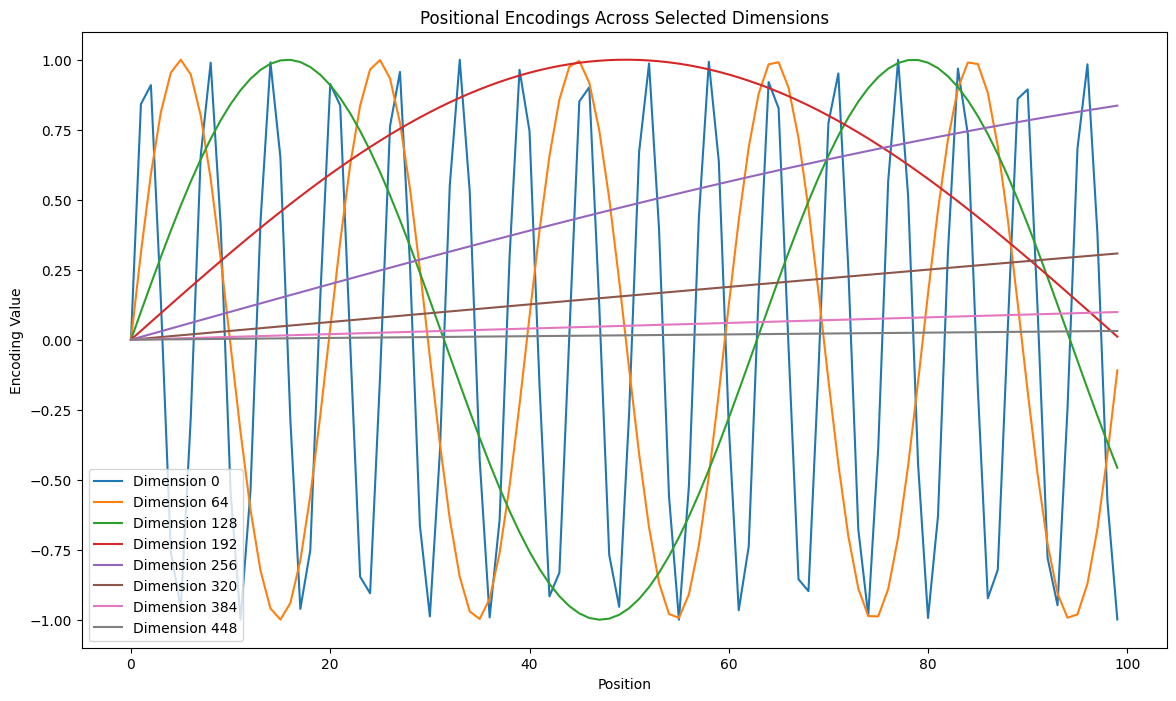

In [218]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
actual_seq_length = 8


dimensions_to_plot = range(0, positional_encodings_np.shape[1], 64)

plt.figure(figsize=(14, 8))
for dim in dimensions_to_plot:
    plt.plot(positional_encodings_np[:, dim], label=f'Dimension {dim}')

plt.title('Positional Encodings Across Selected Dimensions')
plt.xlabel('Position')
plt.ylabel('Encoding Value')
plt.legend()
plt.show()

It looks like there is a lot going on, but if you pick a single dimension and follow its line, you'll see that they all follow sinusoidal patterns over positions.
Earlier dimensions have a much higher frequency whereas later dimensions have a much lower frequency and some even appear linear.

This is by design as the scaling factor 10000^(2*i/d_model) increases as i increases effectively scaling the period of our sin and cos functions.

## Attention Mechanisms

In [219]:
class SelfAttention(nn.Module):
    def __init__(self, args: ModelArgs, attn_mask=False, pad_mask=False):
        super().__init__()
        self.d_out_kq = args.d_model // args.num_heads
        d_out_v = self.d_out_kq
        self.W_q = nn.Linear(args.d_model, self.d_out_kq, bias=False)
        self.W_k = nn.Linear(args.d_model, self.d_out_kq, bias=False)
        self.W_v = nn.Linear(args.d_model, d_out_v, bias=False)
        self.attn_mask = attn_mask
        self.pad_mask=pad_mask
        self.pad_idx = args.pad_idx

    #x_2 for cross attention
    def forward(self, x, encoder_output=None):
        if encoder_output is not None:
            queries = self.W_q(x)
            keys =  self.W_k(encoder_output)
            values =  self.W_v(encoder_output)
        else:
            queries = self.W_q(x)
            keys = self.W_k(x)
            values = self.W_v(x)

        attn_scores = queries @ keys.transpose(-2,-1)
        #for masked attention
        if self.attn_mask:
            block_size = attn_scores.shape[0]
            mask = torch.triu(torch.ones(block_size, block_size), diagonal=1)
            attn_scores = attn_scores.masked_fill(mask.bool(), -torch.inf)
        

        attn_weights = torch.softmax(attn_scores/self.d_out_kq**0.5, dim=-1)
        context_vector = attn_weights @ values

        return context_vector

class MultiHeadAttention(nn.Module):
    def __init__(self, args: ModelArgs, attn_mask=False):
        super().__init__()
        self.attn_mask=attn_mask
        self.heads = nn.ModuleList([SelfAttention(args, self.attn_mask) for _ in range(args.num_heads)])
    
    #x_2 for cross attention
    def forward(self, x, encoder_output=None):
        if encoder_output is not None:
            return torch.cat([head(x, encoder_output) for head in self.heads], dim=-1)
        else:
            return torch.cat([head(x) for head in self.heads], dim=-1)

In [220]:
sa = SelfAttention(model_args)
mha = MultiHeadAttention(model_args)
print(sa)

SelfAttention(
  (W_q): Linear(in_features=512, out_features=64, bias=False)
  (W_k): Linear(in_features=512, out_features=64, bias=False)
  (W_v): Linear(in_features=512, out_features=64, bias=False)
)


In [221]:
print("Self-Attention Context Vector", sa(positional_encodings).shape)
print("Multi-Head Context Vector", mha(positional_encodings).shape)

Self-Attention Context Vector torch.Size([1, 10, 64])
Multi-Head Context Vector torch.Size([1, 10, 512])


In [222]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_in_out, d_hidden, dropout):
        super().__init__()
        self.w1 = nn.Linear(d_in_out, d_hidden)
        self.w2 = nn.Linear(d_hidden, d_in_out)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = F.relu(self.w1(x))
        return self.w2(self.dropout(x))  

In [223]:
ff = PositionWiseFeedForward(model_args.d_model, model_args.d_ff, model_args.dropout)

print(ff)

PositionWiseFeedForward(
  (w1): Linear(in_features=512, out_features=2048, bias=True)
  (w2): Linear(in_features=2048, out_features=512, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


In [224]:
class EncoderLayer(nn.Module):
    def __init__(self, args: ModelArgs):
        super().__init__()
        self.ff = PositionWiseFeedForward(args.d_model, args.d_ff, args.dropout)
        self.mha = MultiHeadAttention(args)
        self.norm1 = nn.LayerNorm(args.d_model)
        self.norm2 = nn.LayerNorm(args.d_model)

    def forward(self, x):
        x = self.norm1(x + self.mha(x))
        return self.norm2(x+self.ff(x))
    
class Encoder(nn.Module):
    def __init__(self, args:ModelArgs):
        super().__init__()
        self.layers = nn.ModuleList([EncoderLayer(args) for _ in range(args.N)])
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [225]:
encoder = Encoder(model_args)
print(len(encoder.layers), "X \n")
encoder_layer = EncoderLayer(model_args)
print(encoder_layer)

6 X 

EncoderLayer(
  (ff): PositionWiseFeedForward(
    (w1): Linear(in_features=512, out_features=2048, bias=True)
    (w2): Linear(in_features=2048, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (mha): MultiHeadAttention(
    (heads): ModuleList(
      (0): SelfAttention(
        (W_q): Linear(in_features=512, out_features=64, bias=False)
        (W_k): Linear(in_features=512, out_features=64, bias=False)
        (W_v): Linear(in_features=512, out_features=64, bias=False)
      )
      (1): SelfAttention(
        (W_q): Linear(in_features=512, out_features=64, bias=False)
        (W_k): Linear(in_features=512, out_features=64, bias=False)
        (W_v): Linear(in_features=512, out_features=64, bias=False)
      )
      (2): SelfAttention(
        (W_q): Linear(in_features=512, out_features=64, bias=False)
        (W_k): Linear(in_features=512, out_features=64, bias=False)
        (W_v): Linear(in_features=512, out_features=64, bias=False)
      )
  

In [226]:
encoded = encoder_layer(positional_encodings)
print(encoded)
print(encoded.shape)

tensor([[[-0.4894,  1.3060, -0.4411,  ..., -0.5799, -0.7959, -0.5042],
         [ 0.3410,  0.5997,  0.1323,  ...,  0.3774, -1.0101,  1.8943],
         [-0.0653, -0.0113, -0.3429,  ...,  0.4869, -0.1164,  0.8836],
         ...,
         [ 0.5629,  0.2373, -0.3424,  ...,  0.3452, -1.4499,  0.9301],
         [ 2.0551, -0.5449,  0.3499,  ..., -0.9304,  0.3402,  0.6112],
         [ 0.2392, -0.9245,  0.4851,  ...,  0.4150, -1.4216, -0.4400]]],
       grad_fn=<NativeLayerNormBackward0>)
torch.Size([1, 10, 512])


In [227]:
class DecoderLayer(nn.Module):
    def __init__(self, args: ModelArgs):
        super().__init__()
        self.mmha = MultiHeadAttention(args, attn_mask=True)
        self.mhca = MultiHeadAttention(args)
        self.ff = PositionWiseFeedForward(args.d_model, args.d_ff, args.dropout)
        self.norm1 = nn.LayerNorm(args.d_model)
        self.norm2 = nn.LayerNorm(args.d_model)
        self.norm3 = nn.LayerNorm(args.d_model)
    
    def forward(self, x, encoder_output):
        x = self.norm1(x+self.mmha(x))
        x = self.norm2(x + self.mhca(x, encoder_output))
        return self.norm3(x + self.ff(x))

class Decoder(nn.Module):
    def __init__(self, args:ModelArgs):
        super().__init__()
        self.layers = nn.ModuleList([DecoderLayer(args) for _ in range(args.N)])
    
    def forward(self, x, encoder_output):
        for layer in self.layers:
            x = layer(x, encoder_output)
        return x

In [228]:
decoder = Decoder(model_args)
print(len(decoder.layers), "X \n")
decoder_layer = DecoderLayer(model_args)
print(decoder_layer)

6 X 

DecoderLayer(
  (mmha): MultiHeadAttention(
    (heads): ModuleList(
      (0): SelfAttention(
        (W_q): Linear(in_features=512, out_features=64, bias=False)
        (W_k): Linear(in_features=512, out_features=64, bias=False)
        (W_v): Linear(in_features=512, out_features=64, bias=False)
      )
      (1): SelfAttention(
        (W_q): Linear(in_features=512, out_features=64, bias=False)
        (W_k): Linear(in_features=512, out_features=64, bias=False)
        (W_v): Linear(in_features=512, out_features=64, bias=False)
      )
      (2): SelfAttention(
        (W_q): Linear(in_features=512, out_features=64, bias=False)
        (W_k): Linear(in_features=512, out_features=64, bias=False)
        (W_v): Linear(in_features=512, out_features=64, bias=False)
      )
      (3): SelfAttention(
        (W_q): Linear(in_features=512, out_features=64, bias=False)
        (W_k): Linear(in_features=512, out_features=64, bias=False)
        (W_v): Linear(in_features=512, out_featur

In [229]:
decoded = decoder(positional_encodings, encoded)
print(decoded)
print(decoded.shape)

tensor([[[ 0.3448, -0.6520,  0.8857,  ...,  0.5630, -0.0368, -0.7194],
         [ 0.8619, -0.5718,  1.3564,  ...,  0.2967, -0.1163,  0.6828],
         [ 0.2292, -0.7783,  1.2308,  ...,  0.5670, -0.5211,  0.5751],
         ...,
         [ 0.6236, -0.6080,  1.2370,  ...,  1.4520, -0.5709,  0.1857],
         [ 1.2337, -1.0000,  1.5391,  ...,  0.0690,  0.8345,  0.7859],
         [ 1.1616, -1.2166,  1.2982,  ...,  0.2778,  0.6085, -1.1951]]],
       grad_fn=<NativeLayerNormBackward0>)
torch.Size([1, 10, 512])


In [230]:
class Transformer(nn.Module):
    def __init__(self, args:ModelArgs):
        super().__init__()
        self.pe = PositionalEncoding(args)
        self.input_emb = Embeddings(args)
        self.output_emb = Embeddings(args)
        self.encoder = Encoder(args)
        self.decoder = Decoder(args)
        self.linear = nn.Linear(args.d_model, args.vocab_size)

        #for weight sharing
        self.input_emb.weight = self.linear.weight
        self.output_emb.weight = self.input_emb.embedding.weight
    
    def forward(self, src, tgt):
        src = self.pe(self.input_emb(src))
        enc_output = self.encoder(src)
        dec_output = self.decoder(self.output_emb(tgt), enc_output)

        return F.softmax(self.linear(dec_output), dim=-1)



In [231]:
model = Transformer(model_args)


output = model(sentence_tensor, sentence_tensor)
print(output)
print(output.shape)

tensor([[[0.1121, 0.0954, 0.0646, 0.1197, 0.0576, 0.1248, 0.0157, 0.0688,
          0.2920, 0.0491],
         [0.1027, 0.0984, 0.0717, 0.1372, 0.0670, 0.1553, 0.0245, 0.0808,
          0.2119, 0.0505],
         [0.1092, 0.0930, 0.0829, 0.1448, 0.0411, 0.0867, 0.0237, 0.0910,
          0.2869, 0.0406],
         [0.1091, 0.0870, 0.0769, 0.1420, 0.0960, 0.0916, 0.0172, 0.1318,
          0.1650, 0.0836],
         [0.0757, 0.0898, 0.0542, 0.2008, 0.0577, 0.1021, 0.0207, 0.1224,
          0.2052, 0.0712],
         [0.0809, 0.0726, 0.0726, 0.0969, 0.0793, 0.1083, 0.0188, 0.1317,
          0.2919, 0.0471],
         [0.1098, 0.1124, 0.0622, 0.0935, 0.0564, 0.0757, 0.0224, 0.0786,
          0.3183, 0.0707],
         [0.1081, 0.1174, 0.0691, 0.0784, 0.0744, 0.1092, 0.0282, 0.0988,
          0.2657, 0.0506],
         [0.1167, 0.1121, 0.0756, 0.1129, 0.0739, 0.0913, 0.0211, 0.0707,
          0.2602, 0.0655],
         [0.0812, 0.0741, 0.0920, 0.1148, 0.0766, 0.1455, 0.0209, 0.0987,
          0.2247,